<a href="https://colab.research.google.com/github/prerna-khanna/Air-Cognizer/blob/master/Image_Retraining_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the Libraries

In [0]:
#!pip install tensorflow-gpu==2.0.0-alpha0
!pip install -U tensorflow_hub
!pip install tf-nightly-gpu

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow as tf

tf.enable_eager_execution()
import tensorflow_hub as hub
print(tf.__version__)

1.14.1-dev20190420


## Classifier

In [0]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}IMAGE_SHAPE = (224, 224)

IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

In [0]:
#!rm  /root/.keras/datasets/detect.tar.gz
!ls "/root/.keras/datasets/flower_photos"

daisy  dandelion  LICENSE.txt  roses  sunflowers  tulips


In [0]:
data_root = tf.keras.utils.get_file(
  'detect','https://drive.google.com/uc?export=download&id=1O3wb-FlPwuLAqsXlj4wTIJ2ggZUU1wiN',
   untar = True)
print(data_root)



48529408/Unknown - 9s 0us/step/root/.keras/datasets/detect


In [0]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(data_root, target_size=IMAGE_SHAPE)

Found 78 images belonging to 2 classes.


In [0]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Labe batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Labe batch shape:  (32, 2)


In [0]:
import numpy as np

labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

result_batch = classifier.predict(image_batch)
result_batch.shape
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

16384/10484 [==============================================] - 0s 0us/step


array(['monastery', 'studio couch', 'file', 'desk', 'castle', 'maze',
       'flute', 'lakeside', 'academic gown', 'rocking chair', 'patio',
       'window shade', 'cinema', 'studio couch', 'dome', 'notebook',
       'mobile home', 'entertainment center', 'castle', 'alp',
       'monastery', 'library', 'crutch', 'laptop', 'dome', 'quilt',
       'studio couch', 'dome', 'castle', 'notebook', 'prison',
       'monastery'], dtype='<U30')

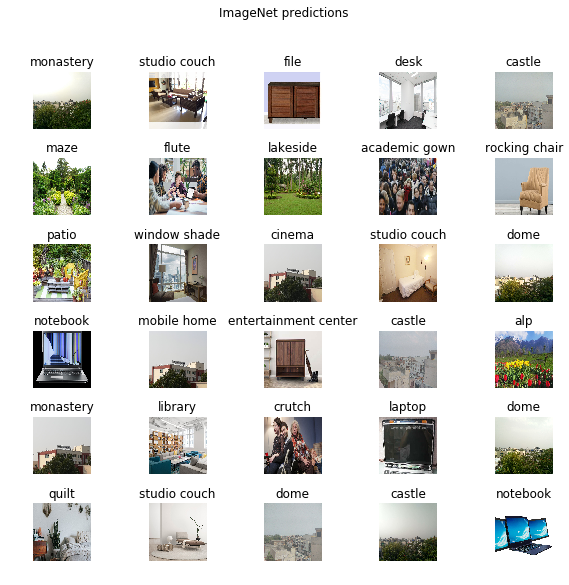

In [0]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [0]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

In [0]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [0]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [0]:
feature_extractor_layer.trainable = False

In [0]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
predictions = model(image_batch)

In [0]:
predictions.shape

TensorShape([Dimension(32), Dimension(2)])

In [0]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [0]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit(image_data, epochs=2,
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats_callback])

Epoch 1/2
3/3 [==============================] - 14s 5s/step - loss: 0.7153 - acc: 0.7188
Epoch 2/2
3/3 [==============================] - 9s 3s/step - loss: 0.5255 - acc: 0.7812


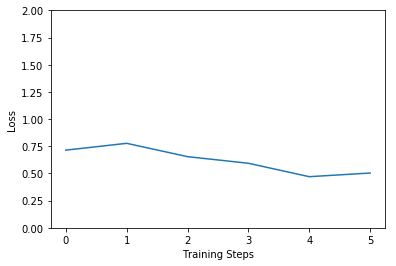

In [0]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

In [0]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['No', 'Sky'], dtype='<U3')

In [0]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

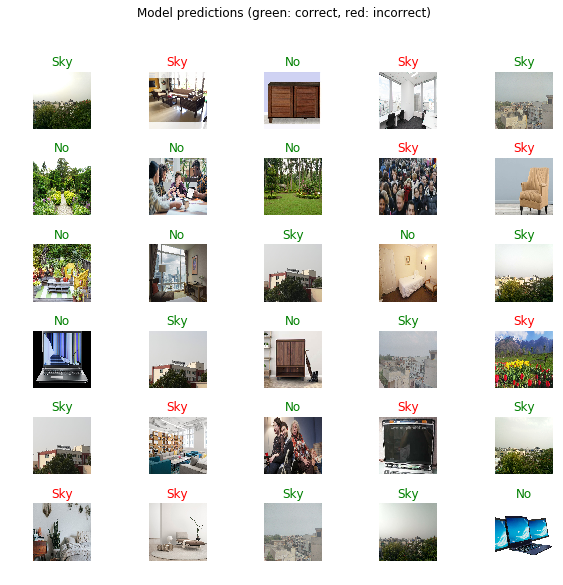

In [0]:
label_id = np.argmax(label_batch, axis=-1)
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")